In [49]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import io
import os
import math
import requests
import plotly.express as px
import seaborn as sns
import itertools
import scipy.stats as stats
import statsmodels.graphics.api as smg
import statsmodels.formula.api as smf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tsa.seasonal import STL 
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa import stattools
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa import stattools as tsat
import statsmodels.graphics.tsaplots as tsap
from statsmodels.tsa.api import SimpleExpSmoothing, Holt, ExponentialSmoothing
from sklearn import preprocessing
from tqdm.notebook import tqdm
from IPython.core.debugger import Pdb
import ipywidgets.widgets as iw


# warning回避
from statsmodels.tools.sm_exceptions import HessianInversionWarning, ConvergenceWarning
import warnings

warnings.simplefilter("ignore", HessianInversionWarning)
warnings.simplefilter("ignore", ConvergenceWarning)
warnings.simplefilter("ignore")

# 誤差のパッケージインポート
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import max_error

 
target = "#demands"


# 対象データ

In [50]:
#予測期間
t_range = np.arange('2015-01', '2020-01',np.timedelta64(1,'M'), dtype='datetime64')

## air passenger

In [95]:
#https://stat.ethz.ch/R-manual/R-devel/library/datasets/html/AirPassengers.html
df_air = pd.read_csv('AirPassengers.csv', encoding="shift jis")
y = pd.Series(df_air["112"][0:60].values, index=t_range)
y = pd.DataFrame(y, columns=['demand'])
y["label"] = "train"
y["Month"] = y.index
train_fil = y["Month"] < "2019-01-01"
test_fil = y["Month"] >= "2019-01-01"
y.loc[test_fil, "label"] = "test"
y.tail()

,demand,label,Month
2019-08-01,237,test,2019-08-01
2019-09-01,211,test,2019-09-01
2019-10-01,180,test,2019-10-01
2019-11-01,201,test,2019-11-01
2019-12-01,204,test,2019-12-01


## sin+外部指標(+トレンド+ノイズ)

In [96]:
import random 
y_ex = pd.DataFrame()
y_ex["Month"] = t_range
y_ex.set_index("Month", inplace=True)
y_ex["sequence"] = pd.RangeIndex(start=0, stop=len(t_range), step=1)
y_ex["ex1"] = [noise() for i in range(len(t_range))]
y_ex["rad"] = math.pi/6*y_ex["sequence"]
y_ex["sin"] = 5* np.sin(y_ex["rad"])
mean, std = 0, 2
y_ex["random"] = [random.gauss(mean, std) for i in range(60)]
y_ex["demand"] = y_ex["sin"]  + 3*y_ex["ex1"] 
#+ y_ex["random"]+ 0.4*y_ex["sequence"]
y_ex["label"] = "train"
y_ex["Month"] = y_ex.index
train_fil = y_ex["Month"] < "2019-01-01"
test_fil = y_ex["Month"] >= "2019-01-01"
y_ex.loc[test_fil, "label"] = "test"
y_ex.tail()

,sequence,ex1,rad,sin,random,demand,label,Month
Month,,,,,,,,
2019-08-01,55,0,28.797933,-2.500000,0.379207,-2.500000,test,2019-08-01
2019-09-01,56,1,29.321531,-4.330127,-1.119885,-1.330127,test,2019-09-01
2019-10-01,57,0,29.845130,-5.000000,-0.831651,-5.000000,test,2019-10-01
2019-11-01,58,0,30.368729,-4.330127,-1.804667,-4.330127,test,2019-11-01
2019-12-01,59,1,30.892328,-2.500000,-2.765167,0.500000,test,2019-12-01


In [53]:
def noise():
    return 1 if random.random() >= 0.7 else 0

In [102]:
def ex_data():
    return y_ex["ex1"]

## 1.ベンチマークモデル

## パラメータ推定

In [59]:
#パラメータの探索範囲の決定
def param_range(data):   
    #階差をとらない場合の周期
    pca = tsat.pacf(data,nlags=20)
    season_0 = abs(pca[2:21]).argmax()+ 2
    
    #階差をとる場合の周期
    diff_data = diff(data)
    pca = tsat.pacf(diff_data,nlags=20)
    season_1 = abs(pca[2:21]).argmax()+ 2
    
    #パラメータ
    p = q = list(range(3))
    d = sd = list(range(2))
    sp = sq = range(2)
    pdq = seasonal_pdq = [(x[0], x[1], x[2]) for x in list(itertools.product(p, d, q))]
    seasonal_pdq = [(x[0], 0, x[2], season_0) for x in list(itertools.product(sp, sd, sq))]
    seasonal_pdq_1 = [(x[0], 1, x[2], season_1) for x in list(itertools.product(sp, sd, sq))]
    seasonal_pdq[len(seasonal_pdq):len(seasonal_pdq)]=seasonal_pdq_1
    return pdq, seasonal_pdq


In [60]:
def AR_param(demand):
    best_param_by_aic = {}    
    _p_list = list(range(3))
    for p in tqdm(_p_list):
        param = (p, 0, 0)
        try:
            model = SARIMAX(
                demand,
                order=(p, 0, 0),
                enforce_stationarity=False,
                enforce_invertibility=False,
            ).fit(disp=1, max_iter=100)

            best_param_by_aic[model.aic] = param
        except:
            pass
    best_param = best_param_by_aic[min(best_param_by_aic)]
    return best_param  

In [61]:
def ARIMA_param(demand):
    best_param_by_aic = {}    
    pdq = param_range(demand)[0]
    for param in pdq:
        try:
            model = SARIMAX(
                demand,
                order=param,
                enforce_stationarity=False,
                enforce_invertibility=False,
            ).fit(disp=1, max_iter=100)

            best_param_by_aic[model.aic] = param
        except:
            pass
    best_param = best_param_by_aic[min(best_param_by_aic)]
    return best_param  

In [62]:
def SARIMA_param(demand):
    best_param_by_aic = {}
    pdq, seasonal_pdq = param_range(demand)
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                model = SARIMAX(
                    demand,
                    order=param,
                    seasonal_order=param_seasonal,
                    enforce_stationarity=False,
                    enforce_invertibility=False,
                ).fit(disp=1, max_iter=100)

                best_param_by_aic[model.aic] = [param, param_seasonal]
            except:
                pass
    best_param = best_param_by_aic[min(best_param_by_aic)]
    return best_param  
    

In [63]:
def ARIMAX_param(demand, ex_indicator):
    best_param_by_aic = {} 
    err_llf_param = {}
    pdq = param_range(demand)[0]
    #pdq = param_range(demand)[0]
    for param in pdq:
        try:
            model = SARIMAX(
                endog=demand,
                exog=ex_indicator,
                order=param,
                enforce_stationarity=False,
                enforce_invertibility=False,
            ).fit(disp=1, max_iter=100)
            # 尤度を正しく計算できないパターンがあるため、例外処理
            if (model.llf_obs == 0).sum() > 0:
                err_llf_param[param] = model.aic
            else:
                best_param_by_aic[model.aic] = param
        except:
            pass
    best_param = best_param_by_aic[min(best_param_by_aic)]
    return best_param  

In [64]:
def SARIMAX_param(demand, ex_indicator):
    best_param_by_aic = {}
    err_llf_param = {}
    pdq, seasonal_pdq = param_range(demand)
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                model = SARIMAX(
                    endog=demand,
                    exog=ex_indicator,
                    order=param,
                    seasonal_order=param_seasonal,
                    enforce_stationarity=False,
                    enforce_invertibility=False,
                ).fit(disp=1, max_iter=100)
                # 尤度を正しく計算できないパターンがあるため、例外処理
                if (model.llf_obs == 0).sum() > 0:
                    err_llf_param[param] = model.aic
                else:
                    best_param_by_aic[model.aic] = [param, param_seasonal]
            except:
                pass
    best_param = best_param_by_aic[min(best_param_by_aic)]
    return best_param  
    

## 予測モデル

In [65]:
def ExponentialSmoothing_df(demand):
    model = ExponentialSmoothing(demand,seasonal_periods=12, trend='add', seasonal='add')
    return model

In [66]:
def AR_df(demand):
    best_param = AR_param(demand)
    model = SARIMAX(demand, order=best_param, enforce_stationarity=False, enforce_invertibility=False)
    return model

In [67]:
def ARMA_df(demand):
    info_criteria = stattools.arma_order_select_ic(demand, ic="aic")
    best_param = (info_criteria.aic_min_order[0], 0, info_criteria.aic_min_order[1])
    model = SARIMAX(demand, order=best_param, enforce_stationarity=False, enforce_invertibility=False)
    return model

In [68]:
def ARIMA_df(demand):
    #パラメータの参照
    best_param = ARIMA_param(demand)
    model = SARIMAX(demand, order=best_param, enforce_stationarity=False, enforce_invertibility=False)
    return model

In [69]:
def SARIMA_df(demand):
    #パラメータの参照
    best_param = SARIMA_param(demand)
    model = SARIMAX(demand, order=best_param[0], seasonal_order = best_param[1], enforce_stationarity=False, enforce_invertibility=False)
    return model
    

In [70]:
def ARIMAX_df(demand, ex_indicator):
    #パラメータの参照
    best_param = ARIMAX_param(demand, ex_indicator)
    model = SARIMAX(endog = demand, exog = ex_indicator, order=best_param, enforce_stationarity=False, enforce_invertibility=False)
    return model

In [71]:
def SARIMAX_df(demand, ex_indicator):
    #パラメータの参照
    best_param = SARIMAX_param(demand, ex_indicator)
    model = SARIMAX(endog = demand, exog = ex_indicator, order=best_param[0], seasonal_order = best_param[1], enforce_stationarity=False, enforce_invertibility=False)
    return model

In [106]:
#モデルによる予測
def predict(method, y):
    model = method(y[train_fil]["demand"])
    fit1 = model.fit(optimized=True)
    y.loc[test_fil,"predict"] = fit1.predict(y[test_fil].index.min(), y[test_fil].index.max())
    y.loc[train_fil,"train_predict"] = fit1.predict(y[train_fil].index.min(), y[train_fil].index.max())

    y_pred = y['predict'][-12:]
    y_true = y['demand'][-12:]
    y_true_ave = np.mean(y['demand'][-12:])
    
    CFE = []
    CAFE = []
    for l in range(len(y_pred)):
        CFE.append(y_true[l] - y_pred[l])
    for m in range(len(y_pred)):
        CAFE.append(sum(np.abs(CFE[:m+1])))
    error_list = [math.sqrt(mean_squared_error(y_true, y_pred)), mean_absolute_error(y_true, y_pred), np.mean(np.abs(y_pred - y_true) / ((np.abs(y_pred)+np.abs(y_true))/2)) * 100, CAFE[11] ]
    
    params = pd.DataFrame(fit1.params, columns=[method.__name__])
    
    return y, error_list, params

In [100]:
#提案モデルによる予測
def pro_predict(method, y):
    ex_indicator = ex_data()
    model = method(y[train_fil]["demand"], ex_indicator[train_fil])
    fit1 = model.fit(optimized=True)
    y.loc[test_fil,"predict"] = fit1.predict(y[test_fil].index.min(), y[test_fil].index.max(), exog=ex_indicator[test_fil])
    y.loc[train_fil,"train_predict"] = fit1.predict(y[train_fil].index.min(), y[train_fil].index.max(), exog=ex_indicator[train_fil])

    
    y_pred = y['predict'][-12:] 
    y_true = y['demand'][-12:]
    y_true_ave = np.mean(y['demand'][-12:])
    
    CFE = []
    CAFE = []
    for l in range(len(y_pred)):
        CFE.append(y_true[l] - y_pred[l])
    for m in range(len(y_pred)):
        CAFE.append(sum(np.abs(CFE[:m+1])))
    error_list = [math.sqrt(mean_squared_error(y_true, y_pred)), mean_absolute_error(y_true, y_pred), np.mean(np.abs(y_pred - y_true) / ((np.abs(y_pred)+np.abs(y_true))/2)) * 100, CAFE[11] ]
    
    params = pd.DataFrame(fit1.params, columns=[method.__name__])
    
    return y, error_list, params

## データの変換、確認

In [74]:
#データを1階差とる
def diff(data):
    data_diff = data.diff()
    data_diff = data_diff.fillna(data_diff.mean())
    return data_diff

In [75]:
#季節性の除去(S階差とる)
def diff_s(data, season):
    data_diff = data.diff(periods=int(season))
    data_diff = data_diff.fillna(data_diff.mean())
    return data_diff

In [76]:
#単位根検定
def dftest(data):
    dftest = adfuller(data)
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    return dfoutput[1]

In [77]:
#コレログラムの描画
def acf_plot(data):
    plot_acf(data, lags=47)
    plot_pacf(data, lags=20)  
    pca = tsat.pacf(data,nlags=20)
    season = pca[2:21].argmax()+2
    print(season)
    return season

In [78]:
# STL分解
def stl_plot(data, season):    
    stl=STL(data, period=season, robust=True)
    stl_series = stl.fit()
    stl_series.plot()

In [79]:
def check_data(data):
    df_p = dftest(data)
    if  df_p > 0.05:
        data = diff(data)
        dftest(data)
    print("偏自己相関")
    season = acf_plot(data)
    stl_plot(data, season)
    data = diff_s(data, season)
    print("季節性除去後の偏自己相関")
    acf_plot(data)

## データ生成

### モデル

In [109]:
AR_method = [SimpleExpSmoothing, Holt, ExponentialSmoothing, AR_df, ARMA_df, ARIMA_df, SARIMA_df]
pro_method = [ARIMAX_df, SARIMAX_df]
method_list = ["SimpleExpSmoothing", "Holt", "ExponentialSmoothing", "AR", "ARMA", "ARIMA", "SARIMA"]
ex_method_list = ["SimpleExpSmoothing", "Holt", "ExponentialSmoothing", "AR", "ARMA", "ARIMA", "SARIMA", "ARIMAX", "SARIMAX"]

In [81]:
error_name_list = ["RMSE", "MAE", "MAPEs", "CAFE"]

### 保存先変更

In [83]:
file_name = "result1"

In [84]:
kara = pd.DataFrame([])
kara.to_csv('{}.csv'.format(file_name))

## 予測

## 予測実行

Empty DataFrame
Columns: [SimpleExpSmoothing]
Index: []
Empty DataFrame
Columns: [Holt]
Index: []
Empty DataFrame
Columns: [ExponentialSmoothing]
Index: []


  0%|          | 0/3 [00:00<?, ?it/s]

             AR_df
ar.L1     1.172198
ar.L2    -0.170935
sigma2  248.398911
           ARMA_df
ar.L1     2.330365
ar.L2    -2.062035
ar.L3     0.737027
ma.L1    -1.481763
ma.L2     0.483378
sigma2  164.904051
          ARIMA_df
ar.L1     0.978138
ar.L2    -1.012982
ma.L1    -0.917493
ma.L2     1.000001
sigma2  157.038243
          SARIMA_df
ma.L1      0.312255
ma.L2      0.999990
ar.S.L18  -1.018447
ma.S.L18  -0.341550
sigma2    68.719435
       SimpleExpSmoothing        Holt  ExponentialSmoothing          AR  \
RMSE            39.864353   34.597645             39.864353   38.429867   
MAE             32.333333   28.784938             32.333333   30.692570   
MAPEs           14.744976   12.958136             14.744976   13.920971   
CAFE           388.000000  345.419252            388.000000  368.310845   

             ARMA       ARIMA      SARIMA min_method  
RMSE    32.362303   50.165765   16.329501     SARIMA  
MAE     25.690091   43.369370   14.926769     SARIMA  
MAPEs   11.29722

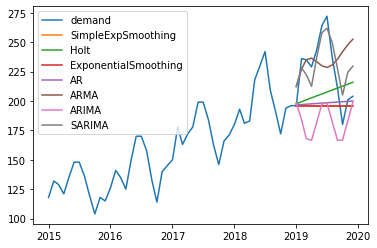

In [111]:
#Xなし
def main(y):
    error_lists = []
    demand = pd.DataFrame(y["demand"])
    demand["Month"] = y["Month"]
    
    for i in AR_method:
        tmp_df, error_list, params = predict(i, y)
        error_lists.append(error_list)
        demand[str(i)] = tmp_df["predict"]
        tmp_df.to_csv('{}\\{}.csv'.format(save_dir, file_name), mode='a')
        params.to_csv('{}\\{}.csv'.format(save_dir, file_name), mode='a')
        print(params)
    
    error_metrics = pd.DataFrame(error_lists, columns = error_name_list, index = method_list).T
    error_metrics["min_method"] = error_metrics.idxmin(axis=1)
    error_metrics.to_csv('{}\\{}.csv'.format(save_dir, file_name), mode='a')
    print(error_metrics)
    plt.plot(demand.index, demand["demand"], label="demand")
    for i in range(len(AR_method)):
        plt.plot(demand.index, demand[str(AR_method[i])], label=method_list[i])
    plt.legend()
    
if __name__ == "__main__":
    main(y)

Empty DataFrame
Columns: [SimpleExpSmoothing]
Index: []
Empty DataFrame
Columns: [Holt]
Index: []
Empty DataFrame
Columns: [ExponentialSmoothing]
Index: []


  0%|          | 0/3 [00:00<?, ?it/s]

           AR_df
ar.L1   0.910459
ar.L2  -0.197659
sigma2  6.485283
         ARMA_df
ar.L1   1.720486
ar.L2  -0.992607
ma.L1  -1.673981
ma.L2   1.000002
sigma2  2.485858
        ARIMA_df
ar.L1   1.720486
ar.L2  -0.992607
ma.L1  -1.673981
ma.L2   1.000002
sigma2  2.485858
          SARIMA_df
ma.L1      0.677338
ma.L2      0.780823
ma.S.L20   3.243330
sigma2     0.014117
           ARIMAX_df
ex1     2.999999e+00
ar.L1   1.732049e+00
ar.L2  -1.000000e+00
sigma2  2.159233e-10
          SARIMAX_df
ex1     2.999999e+00
ar.L1   1.732049e+00
ar.L2  -1.000000e+00
sigma2  2.159233e-10
       SimpleExpSmoothing        Holt  ExponentialSmoothing          AR  \
RMSE             5.082808    9.556442              5.082808    4.030005   
MAE              4.221688    7.445165              4.221688    3.453911   
MAPEs          148.445371  146.603420            148.445371  199.287665   
CAFE            50.660254   89.341983             50.660254   41.446935   

            ARMA      ARIMA      SARIMA   

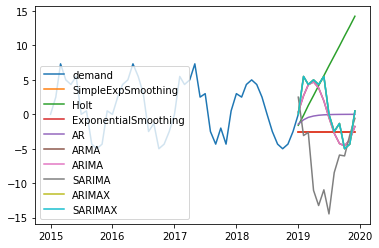

In [112]:
#Xあり
def main(y):
    error_lists = []
    demand = pd.DataFrame(y["demand"])
    demand["Month"] = y["Month"]
    
    for i in AR_method:
        tmp_df, error_list, params = predict(i, y)
        error_lists.append(error_list)
        demand[str(i)] = tmp_df["predict"]
        tmp_df.to_csv('{}\\{}.csv'.format(save_dir, file_name), mode='a')
        params.to_csv('{}\\{}.csv'.format(save_dir, file_name), mode='a')
        print(params)
    
    for i in pro_method:
        tmp_df, error_list, params = pro_predict(i, y)
        error_lists.append(error_list)
        demand[str(i)] = tmp_df["predict"]
        tmp_df.to_csv('{}.csv'.format(file_name), mode='a')
        params.to_csv('{}.csv'.format(file_name), mode='a')
        print(params)
        
    error_metrics = pd.DataFrame(error_lists, columns = error_name_list, index = ex_method_list).T
    error_metrics["min_method"] = error_metrics.idxmin(axis=1)
    error_metrics.to_csv('{}.csv'.format(file_name), mode='a')
    plt.plot(demand.index, demand["demand"], label="demand")
    for i in range(len(AR_method)):
        plt.plot(demand.index, demand[str(AR_method[i])], label=ex_method_list[i])
    for i in range(len(pro_method)):
        plt.plot(demand.index, demand[str(pro_method[i])], label=ex_method_list[i+len(AR_method)])
    plt.legend()
    print(error_metrics)
if __name__ == "__main__":
    main(y_ex)

## 編集中

In [57]:
#ラグ1,2を取った外部変数を追加
def diff_1_2(ex_indicator):
    #ラグ1
    diff1_ex_indicator = ex_indicator.shift()
    diff1_ex_indicator = diff1_ex_indicator.fillna(diff1_ex_indicator.mean())
    diff1_col = diff1_ex_indicator.columns
    diff2_col = ex_indicator.columns
    
    #行、列名の設定
    diff1_col = list(map(lambda x: x + "-1", diff1_col))
    diff1_ex_indicator = diff1_ex_indicator.set_axis(diff1_col, axis=1)
    diff1_ex_indicator = diff1_ex_indicator.set_axis(ex_indicator.index)
    ex_indicator = ex_indicator.join(diff1_ex_indicator)
    
    #ラグ2
    diff2_ex_indicator = diff1_ex_indicator.shift()
    
    
    diff2_ex_indicator = diff2_ex_indicator.fillna(diff2_ex_indicator.mean())
    
    
    
    #行、列名の設定
    diff2_col = list(map(lambda x: x + "-2", diff2_col))
    diff2_ex_indicator = diff2_ex_indicator.set_axis(diff2_col, axis=1)
    diff2_ex_indicator = diff2_ex_indicator.set_axis(ex_indicator.index)
    ex_indicator = ex_indicator.join(diff2_ex_indicator)
    
    
    #ex_indicator = diff1_ex_indicator
    #ex_indicator = ex_indicator.append(diff1_ex_indicator)
    return ex_indicator

In [58]:
#VIF10以下になるように削除
def auto_del(ex_indicator):
    #if len(ex_indicator.columns) > 2:
    #ex_indicator = ex_indicator.drop(['industry'], axis=1)
    vif_data = pd.DataFrame()
    vif_data["feature"] = ex_indicator.columns
    vif_data["VIF"] = [variance_inflation_factor(ex_indicator.values, i) for i in range(len(ex_indicator.columns))]
    vif_data
    #Pdb().set_trace()
    while vif_data.max()['VIF'] > 10:
        ex_indicator = ex_indicator.drop([vif_data.feature[vif_data["VIF"].idxmax()]], axis=1)
        vif_data = pd.DataFrame()
        vif_data["feature"] = ex_indicator.columns
        vif_data["VIF"] = [variance_inflation_factor(ex_indicator.values, i) for i in range(len(ex_indicator.columns))]
    #Pdb().set_trace()
    return ex_indicator